In [7]:
import pandas as pd
import numpy as np
import math

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from category_encoders import CountEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt

import os
import json
import shutil

In [8]:
# from google.colab import userdata, drive
# drive.mount('/content/drive')


### Data downloading:

In [9]:
# Install kaggle CLI if needed
if shutil.which('kaggle') is None:
    %pip install -q kaggle 

kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")

# Prompt for credentials
user = input("Kaggle username: ").strip()
key = input("Kaggle API key: ").strip()

os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)
with open(kaggle_json_path, "w") as f:
    json.dump({"username": user, "key": key}, f)
    
# Secure the file so the Kaggle API doesn't complain
os.chmod(kaggle_json_path, 0o600)

# Download the competition dataset into ./data
!kaggle competitions download -c DontGetKicked -p ./data

! unzip ./data/DontGetKicked.zip -d ./data/
! rm ./data/DontGetKicked.zip

print("Dataset downloaded successfully!")

Kaggle username:  doniyor117
Kaggle API key:  f3e6405ba70cbe0f493223e5ad02c284


100%|██████████████████████████████████████| 10.2M/10.2M [00:06<00:00, 1.62MB/s]

Dataset downloaded successfully!


### Reading the data:

In [12]:
data_full = pd.read_csv('./data/training.csv')
pd.set_option('display.max_columns', 200)
data_full

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,73010,1,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,BLACK,AUTO,1.0,Alloy,45234,AMERICAN,MEDIUM,FORD,1996.0,2993.0,2656.0,3732.0,2190.0,3055.0,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
72979,73011,0,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,SILVER,AUTO,NaN,NaN,71759,AMERICAN,MEDIUM,GM,6418.0,7325.0,7431.0,8411.0,6785.0,8132.0,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
72980,73012,0,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,SILVER,AUTO,1.0,Alloy,88500,AMERICAN,MEDIUM SUV,CHRYSLER,8545.0,9959.0,9729.0,11256.0,8375.0,9802.0,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893
72981,73013,0,12/2/2009,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,WHITE,AUTO,1.0,Alloy,79554,AMERICAN,LARGE,GM,6420.0,7604.0,7434.0,8712.0,6590.0,7684.0,10099.0,11228.0,NaN,NaN,18881,30212,GA,7000.0,0,1974


In [39]:
! cat '/content/drive/MyDrive/Machine_Learning/school21/ml4/data/Carvana_Data_Dictionary.txt'

Field Name				Definition
RefID				        Unique (sequential) number assigned to vehicles
IsBadBuy				Identifies if the kicked vehicle was an avoidable purchase 
PurchDate				The Date the vehicle was Purchased at Auction
Auction					Auction provider at which the  vehicle was purchased
VehYear					The manufacturer's year of the vehicle
VehicleAge				The Years elapsed since the manufacturer's year
Make					Vehicle Manufacturer 
Model					Vehicle Model
Trim					Vehicle Trim Level
SubModel				Vehicle Submodel
Color					Vehicle Color
Transmission				Vehicles transmission type (Automatic, Manual)
WheelTypeID				The type id of the vehicle wheel
WheelType				The vehicle wheel type description (Alloy, Covers)
VehOdo					The vehicles odometer reading
Nationality				The Manufacturer's country
Size					The size category of the vehicle (Compact, SUV, etc.)
TopThreeAmericanName			Identifies if the manufacturer is one of the top three American manufacturers
MMRAcquisitionAuctionAveragePrice	Acquisiti

In [40]:
data_full['PurchDate'] = pd.to_datetime(data_full['PurchDate'])
data_full = data_full.sort_values(by='PurchDate').reset_index(drop=True)

### Splitting into train, validation, and test:

In [41]:
val_split_pos = len(data_full)//3
test_split_pos = val_split_pos * 2

train_df = data_full.iloc[:val_split_pos].copy()
val_df = data_full.iloc[val_split_pos:test_split_pos].copy()
test_df = data_full.iloc[test_split_pos:].copy()

# get the target (y) values
y_train = train_df['IsBadBuy']
y_val = val_df['IsBadBuy']
y_test = test_df['IsBadBuy']

# drop target values from X
train_df = train_df.drop(columns='IsBadBuy')
val_df = val_df.drop(columns='IsBadBuy')
test_df = test_df.drop(columns='IsBadBuy')

### Target distribution:

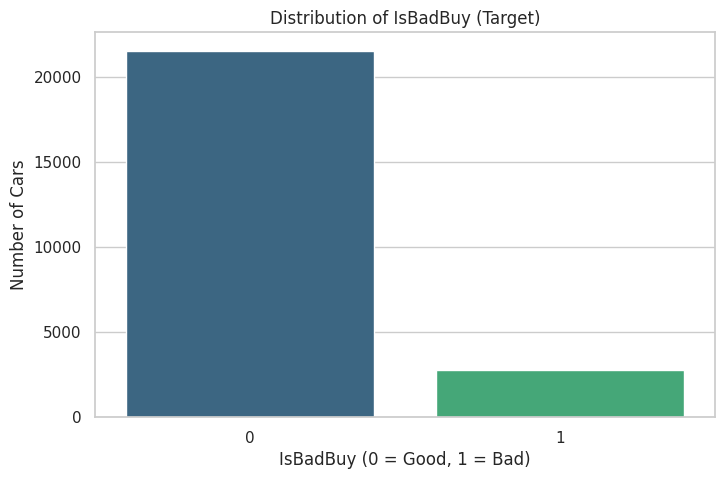

In [42]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, hue=y_train, palette="viridis", legend=False)

plt.title("Distribution of IsBadBuy (Target)")
plt.xlabel("IsBadBuy (0 = Good, 1 = Bad)")
plt.ylabel("Number of Cars")
plt.show()

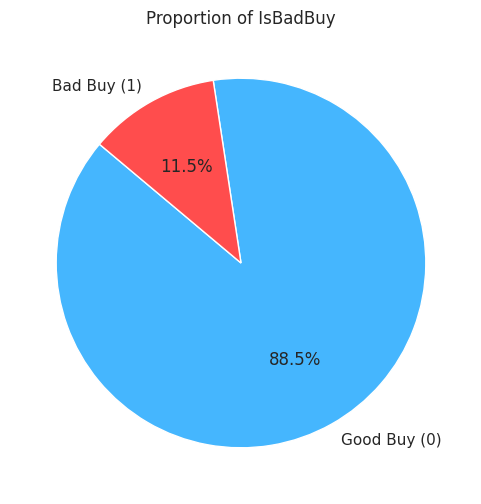

In [43]:
counts = y_train.value_counts()
labels = ['Good Buy (0)', 'Bad Buy (1)']

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#45b6fe', '#ff4d4d'])
plt.title("Proportion of IsBadBuy")
plt.show()

### Encoding:

In [44]:
train_df

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,32389,2009-01-05,MANHEIM,2007,2,CHRYSLER,PACIFICA FWD 3.8L V6,Bas,4D SPORT,BLUE,AUTO,2.0,Covers,78541,AMERICAN,CROSSOVER,CHRYSLER,7261.0,8857.0,8342.0,10066.0,8709.0,10331.0,9906.0,11657.0,NaN,NaN,3453,80022,CO,6770.0,0,1389
1,32406,2009-01-05,MANHEIM,2005,4,FORD,FREESTAR FWD V6 3.9L,SES,4D PASSENGER 3.9L SES,SILVER,AUTO,1.0,Alloy,37676,AMERICAN,VAN,FORD,4409.0,5734.0,5262.0,6693.0,4908.0,5971.0,5801.0,6949.0,NaN,NaN,22916,80022,CO,6160.0,0,941
2,32407,2009-01-05,MANHEIM,2004,5,DODGE,STRATUS 4C 2.4L I4 M,SE,4D SEDAN SE,SILVER,AUTO,2.0,Covers,71680,AMERICAN,MEDIUM,CHRYSLER,3098.0,4061.0,3846.0,4886.0,3397.0,4272.0,4169.0,5114.0,NaN,NaN,3453,80022,CO,4250.0,0,1155
3,32408,2009-01-05,MANHEIM,2006,3,CHEVROLET,TRAILBLAZER EXT 4WD,LS,4D SUV 4.2L,WHITE,AUTO,1.0,Alloy,69456,AMERICAN,MEDIUM SUV,GM,8530.0,9883.0,9712.0,11174.0,9202.0,10794.0,10438.0,12158.0,NaN,NaN,22916,80022,CO,8180.0,0,1703
4,32409,2009-01-05,MANHEIM,2004,5,FORD,TAURUS 3.0L V6 EFI,SES,4D SEDAN SES DURATEC,GOLD,AUTO,1.0,Alloy,66530,AMERICAN,MEDIUM,FORD,3094.0,4230.0,3842.0,5068.0,3369.0,4492.0,4139.0,5351.0,NaN,NaN,22916,80022,CO,4900.0,0,825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24322,56894,2009-09-15,MANHEIM,2005,4,CHEVROLET,AVEO 1.6L I4 EFI,LS,4D SEDAN,WHITE,AUTO,2.0,Covers,70531,AMERICAN,COMPACT,GM,3150.0,4011.0,3902.0,4832.0,3148.0,3829.0,6341.0,7085.0,NaN,NaN,23359,92504,CA,4085.0,0,803
24323,56893,2009-09-15,MANHEIM,2008,1,DODGE,AVENGER 4C 2.4L I4 S,SE,4D SEDAN,BLUE,AUTO,2.0,Covers,64301,AMERICAN,MEDIUM,CHRYSLER,8607.0,9350.0,9796.0,10598.0,7965.0,8884.0,11871.0,12554.0,NaN,NaN,23359,92504,CA,7555.0,0,1020
24324,56892,2009-09-15,MANHEIM,2008,1,DODGE,AVENGER 4C 2.4L I4 S,SE,4D SEDAN,RED,AUTO,2.0,Covers,64524,AMERICAN,MEDIUM,CHRYSLER,8607.0,9350.0,9796.0,10598.0,8568.0,9325.0,9753.0,10571.0,NaN,NaN,23359,92504,CA,7555.0,0,1020
24325,15848,2009-09-15,MANHEIM,2006,3,MAZDA,MAZDA6 2.3L I4 MFI /,i,4D SEDAN I,SILVER,AUTO,2.0,Covers,78217,OTHER ASIAN,MEDIUM,OTHER,8702.0,10517.0,9898.0,11858.0,7590.0,9063.0,8697.0,10288.0,NaN,NaN,20207,77041,TX,7695.0,0,1272


In [64]:
NUM_COLS = [
    'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
    'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
    'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost'
    ]
CAT_SMALL = [
    'Auction', 'Make', 'Color', 'Transmission', 'WheelType',
    'Nationality', 'Size', 'TopThreeAmericanName', 'IsOnlineSale',
    'PRIMEUNIT', 'AUCGUART'
    ]
CAT_LARGE = [
    'Model', 'Trim', 'SubModel', 'VNST', 'VNZIP1'
    ]

In [65]:
def get_preprocessor(NUM_COLS: list, CAT_SMALL: list, CAT_LARGE: list):
  # --- 1. DEFINE THE MINI-PIPELINES ---
  # A. Numeric: Fill -> Scale
  num_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='mean')),
      ('scaler', RobustScaler())
  ])

  # B. Small Cat: Fill -> OneHot
  cat_small_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
  ])

  # C. Large Cat: Fill -> Count Encode
  # Syntax Note: min_group_size=0 ensures new values in Test get mapped to 0 (or low count)
  cat_large_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
      ('count', CountEncoder(handle_unknown=0, handle_missing=0)),
      ('scaler', RobustScaler())
  ])

  # --- 2. THE MASTER PROCESSOR (ColumnTransformer) ---
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', num_pipe, NUM_COLS),
          ('small', cat_small_pipe, CAT_SMALL),
          ('large', cat_large_pipe, CAT_LARGE)
      ],
      remainder='drop',
      verbose_feature_names_out=False
  )
  preprocessor.set_output(transform="pandas")

  return preprocessor

In [66]:
preprocessor = get_preprocessor(NUM_COLS=NUM_COLS, CAT_SMALL=CAT_SMALL, CAT_LARGE=CAT_LARGE)

X_train = preprocessor.fit_transform(train_df)
X_val = preprocessor.transform(val_df)

In [67]:
X_train

,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HUMMER,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PLYMOUTH,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_VOLKSWAGEN,Color_BEIGE,Color_BLACK,Color_BLUE,Color_BROWN,Color_GOLD,Color_GREEN,Color_GREY,Color_MAROON,Color_Missing,Color_NOT AVAIL,Color_ORANGE,Color_OTHER,Color_PURPLE,Color_RED,Color_SILVER,Color_WHITE,Color_YELLOW,Transmission_AUTO,Transmission_MANUAL,Transmission_Missing,WheelType_Alloy,WheelType_Covers,WheelType_Missing,WheelType_Special,Nationality_AMERICAN,Nationality_OTHER,Nationality_OTHER ASIAN,Nationality_TOP LINE ASIAN,Size_COMPACT,Size_CROSSOVER,Size_LARGE,Size_LARGE SUV,Size_LARGE TRUCK,Size_MEDIUM,Size_MEDIUM SUV,Size_SMALL SUV,Size_SMALL TRUCK,Size_SPECIALTY,Size_SPORTS,Size_VAN,TopThreeAmericanName_CHRYSLER,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,IsOnlineSale_0,PRIMEUNIT_Missing,PRIMEUNIT_YES,AUCGUART_GREEN,AUCGUART_Missing,Model,Trim,SubModel,VNST,VNZIP1
0,-1.0,0.342976,0.491139,0.583576,0.491274,0.583834,0.883462,0.948401,0.840909,0.890693,0.223529,0.247511,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.243056,0.960583,0.067847,-0.202885,1.114350
1,0.0,-1.688289,-0.311111,-0.243709,-0.311018,-0.243591,-0.202228,-0.223327,-0.219267,-0.250364,-0.015686,-0.389758,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.486111,-0.455449,-0.107670,-0.202885,1.114350
2,0.5,0.001939,-0.679887,-0.686887,-0.679865,-0.686864,-0.633819,-0.679925,-0.640754,-0.695104,-0.764706,-0.085349,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.281250,0.593574,0.910767,-0.202885,1.114350
3,-0.5,-0.108609,0.848101,0.855364,0.848138,0.855636,1.024279,1.072830,0.978306,1.012118,0.776471,0.694168,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.395833,0.446505,-0.011062,-0.202885,1.114350
4,0.5,-0.254051,-0.681013,-0.642119,-0.680906,-0.642218,-0.641817,-0.620801,-0.648502,-0.637664,-0.509804,-0.554765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.729167,-0.455449,-0.098820,-0.202885,1.114350
...,...,...,...,...,...

### Training and Predictions with the models (LogisticRegression, GaussianNB, KNN):

In [68]:
lr = LogisticRegression(solver='liblinear', C=1.0, random_state=21)

nb = GaussianNB()

K = 50
knn = KNeighborsClassifier(n_neighbors=K, weights='distance', n_jobs=-1)

In [69]:
models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "KNN": knn
}

for name, model in models.items():
  model.fit(X_train, y_train)

  y_pred_proba = model.predict_proba(X_val)[:, 1]

  auc = roc_auc_score(y_true=y_val, y_score=y_pred_proba)

  gini = 2 * auc - 1

  print(f'{name}: AUC = {auc:.4f} | Gini = {gini:.4f}')

Logistic Regression: AUC = 0.7188 | Gini = 0.4375
Naive Bayes: AUC = 0.6911 | Gini = 0.3821
KNN: AUC = 0.6921 | Gini = 0.3842


### Implementing the models and the metric (gini) from scratch:

In [51]:
def my_gini(y_true, y_probs):
    # Check inputs
    y_true = np.asarray(y_true)
    y_probs = np.asarray(y_probs)

    # 1. Sort by probability (High to Low)
    # We use argsort to get indices, then reverse them [::-1]
    sorted_indices = np.argsort(y_probs)[::-1]
    y_true_sorted = y_true[sorted_indices]

    # 2. Calculate AUC (Geometry method)
    # Cumulative sum of positives
    cum_pos = np.cumsum(y_true_sorted)
    # Sum of cumulative positives where the label is actually 0 (Negative)
    # This counts how many Positives are "ranked higher" than each Negative
    sum_pos_ranked_higher = np.sum(cum_pos[y_true_sorted == 0])

    # Total Positives and Negatives
    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos

    # Prevent division by zero
    if n_pos == 0 or n_neg == 0:
        return 0.0

    auc = sum_pos_ranked_higher / (n_pos * n_neg)

    # 3. Convert to Gini
    gini = 2 * auc - 1
    return gini

# Test it against sklearn
# print(f"My Gini: {my_gini(y_val, probs)}")
# print(f"Sklearn Gini: {2*roc_auc_score(y_val, probs) - 1}")

In [52]:
class MyNaiveBayes:
    def fit(self, X, y):
        # 1. Separate the classes
        X0 = X[y == 0] # Safe cars
        X1 = X[y == 1] # Lemons

        # 2. Calculate Mean and Variance for each feature per class
        # (This assumes Gaussian distribution, just like sklearn)
        self.mean0 = X0.mean(axis=0)
        self.std0 = X0.std(axis=0) + 1e-9 # Add tiny noise to avoid div/0

        self.mean1 = X1.mean(axis=0)
        self.std1 = X1.std(axis=0) + 1e-9

        # Prior probability (How common are Lemons generally?)
        self.prior1 = len(X1) / len(X)
        self.prior0 = len(X0) / len(X)

    def predict_proba(self, X):
        # Gaussian Probability Density Function formula
        # P(x|class) = (1 / sqrt(2*pi*std^2)) * exp(-(x-mean)^2 / (2*std^2))

        # We use Log-Probabilities to prevent "underflow" (numbers getting too small)
        # Log(P(Class0)) + Sum(Log(P(Feature|Class0)))

        def get_log_likelihood(X, mean, std):
            exponent = -0.5 * ((X - mean) / std) ** 2
            log_coeff = -np.log(std * np.sqrt(2 * np.pi))
            return np.sum(log_coeff + exponent, axis=1)

        log_prob0 = np.log(self.prior0) + get_log_likelihood(X, self.mean0, self.std0)
        log_prob1 = np.log(self.prior1) + get_log_likelihood(X, self.mean1, self.std1)

        # Convert back to probability: P(1) = 1 / (1 + exp(log_p0 - log_p1))
        # This is the Softmax function for binary classification
        return 1 / (1 + np.exp(log_prob0 - log_prob1))

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

In [53]:
from scipy.stats import mode

class MyKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        # KNN is "Lazy". It just memorizes the training data.
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)

    def predict_proba(self, X):
        X = np.asarray(X)
        predictions = []

        # Loop through every single car we want to predict
        for i, x_query in enumerate(X):
            # 1. Calculate Euclidean Distance to ALL training points
            # sqrt((x1-x2)^2 + (y1-y2)^2...)
            distances = np.sqrt(np.sum((self.X_train - x_query)**2, axis=1))

            # 2. Find the K nearest indices
            nearest_indices = np.argsort(distances)[:self.k]

            # 3. Get their labels
            nearest_labels = self.y_train[nearest_indices]

            # 4. Calculate Probability (Average of labels)
            # If 3 neighbors are 1 and 2 are 0 -> Prob = 3/5 = 0.6
            prob = np.mean(nearest_labels)
            predictions.append(prob)

        return np.array(predictions)

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

### Logistic Regression from scratch:

In [54]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        # TODO: Implement the S-curve formula
        y_hat = 1 / (1 + np.exp(-z))
        return y_hat

    def fit(self, X, y):
        # 1. Initialize weights and bias
        # 2. Loop for n_epochs:
        #    a. Forward Pass (Make a guess)
        #    b. Calculate Gradient (Measure the error direction)
        #    c. Update Weights (Take a step downhill)
        self.weights = np.zeros(X.shape[1])
        self.bias = np.zeros(1)

        for i in range(self.epochs):
          z = np.dot(X, self.weights) + self.bias

          error = self.sigmoid(z) - y

          gradient_w = (np.dot(X.T, error)) / X.shape[0]
          self.weights = self.weights - self.lr * gradient_w

          gradient_b = np.mean(error)
          self.bias = self.bias - self.lr * gradient_b

        return

    def predict_proba(self, X):
        # 1. Calculate z = X * w + b
        # 2. Return sigmoid(z)
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        # 1. Get probabilities
        # 2. Return 1 if prob > threshold, else 0
        y_probs = self.predict_proba(X)

        return np.where(y_probs > threshold, 1, 0)

### Feature engineering:

In [70]:
def engineer_features(df, learned_dict=None):
    df = df.copy()

    df['Miles_Per_Year'] = df['VehOdo'] / (df['VehicleAge'] + 1)
    df['Warranty_Ratio'] = df['WarrantyCost'] / (df['VehBCost'] + 1)
    df['MMR_Markup'] = df['MMRCurrentRetailAveragePrice'] - df['MMRCurrentAuctionAveragePrice']

    # --- FIX THE LEAK ---
    if learned_dict is None:
        # We are Training! Learn the dictionary
        learned_dict = df.groupby('Make')['VehBCost'].mean().to_dict()

    # Map using the learned dictionary
    df['Make_Avg_Cost'] = df['Make'].map(learned_dict)

    # If Val has a new 'Make', it becomes NaN. Fill it with the global average.
    df['Make_Avg_Cost'] = df['Make_Avg_Cost'].fillna(df['VehBCost'].mean())
    df['Cost_Diff_From_Make_Avg'] = df['VehBCost'] - df['Make_Avg_Cost']

    return df, learned_dict

In [71]:
NUM_COLS_NEW = [
    'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
    'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
    'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost', 'Miles_Per_Year',
    'Warranty_Ratio', 'MMR_Markup', 'Make_Avg_Cost', 'Cost_Diff_From_Make_Avg',
    ]

In [72]:
train_df_en, make_dict = engineer_features(train_df, learned_dict=None)
val_df_en, _ = engineer_features(val_df, learned_dict=make_dict)

preprocessor = get_preprocessor(NUM_COLS=NUM_COLS_NEW, CAT_SMALL=CAT_SMALL, CAT_LARGE=CAT_LARGE)

X_train = preprocessor.fit_transform(train_df_en)
X_val = preprocessor.transform(val_df_en)

In [73]:
lr = LogisticRegression(solver='liblinear', C=1.0, random_state=21)

nb = GaussianNB()

K = 50
knn = KNeighborsClassifier(n_neighbors=K, weights='distance', n_jobs=-1)

In [74]:
models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "KNN": knn
}

for name, model in models.items():
  model.fit(X_train, y_train)

  y_pred_proba = model.predict_proba(X_val)[:, 1]

  auc = roc_auc_score(y_true=y_val, y_score=y_pred_proba)

  gini = 2 * auc - 1

  print(f'{name}: AUC = {auc:.4f} | Gini = {gini:.4f}')

Logistic Regression: AUC = 0.7177 | Gini = 0.4355
Naive Bayes: AUC = 0.7028 | Gini = 0.4057
KNN: AUC = 0.6339 | Gini = 0.2677


### Feature elimination:

In [75]:
weights = lr.coef_
bias = lr.intercept_
columns = X_train.columns

#### Manual:

In [98]:
col_importance = pd.DataFrame({'col_names': columns, 'weights': np.abs(weights).flatten()})
col_importance.sort_values(by='weights', ascending=True).iloc[:30]

,col_names,weights
21,Make_BUICK,0.002029
47,Make_SUBARU,0.003395
22,Make_CADILLAC,0.003869
44,Make_PONTIAC,0.003908
37,Make_MAZDA,0.007034
25,Make_DODGE,0.017231
18,Auction_MANHEIM,0.019144
82,Size_LARGE SUV,0.020475
88,Size_SPECIALTY,0.022081
56,Color_GREEN,0.022679


In [100]:
NUM_COLS_NEW = [
    'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
    'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
    'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost', 'Miles_Per_Year',
    'Warranty_Ratio', 'Cost_Diff_From_Make_Avg',
    ]
CAT_SMALL_NEW = [
    'Auction', 'Transmission', 'WheelType',
    'Nationality', 'Size', 'TopThreeAmericanName', 'IsOnlineSale',
    'PRIMEUNIT', 'AUCGUART'
    ]
CAT_LARGE_NEW = [
    'Model', 'VNST', 'VNZIP1'
    ]

In [101]:
train_df_en, make_dict = engineer_features(train_df, learned_dict=None)
val_df_en, _ = engineer_features(val_df, learned_dict=make_dict)

preprocessor = get_preprocessor(NUM_COLS=NUM_COLS_NEW, CAT_SMALL=CAT_SMALL_NEW, CAT_LARGE=CAT_LARGE_NEW)

X_train = preprocessor.fit_transform(train_df_en)
X_val = preprocessor.transform(val_df_en)


lr = LogisticRegression(solver='liblinear', C=1.0, random_state=21)

nb = GaussianNB()

K = 50
knn = KNeighborsClassifier(n_neighbors=K, weights='distance', n_jobs=-1)

In [102]:
models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "KNN": knn
}

for name, model in models.items():
  model.fit(X_train, y_train)

  y_pred_proba = model.predict_proba(X_val)[:, 1]

  auc = roc_auc_score(y_true=y_val, y_score=y_pred_proba)

  gini = 2 * auc - 1

  print(f'{name}: AUC = {auc:.4f} | Gini = {gini:.4f}')

Logistic Regression: AUC = 0.7194 | Gini = 0.4388
Naive Bayes: AUC = 0.7188 | Gini = 0.4377
KNN: AUC = 0.7020 | Gini = 0.4041


#### With L1:

In [142]:
train_df_en, make_dict = engineer_features(train_df, learned_dict=None)
val_df_en, _ = engineer_features(val_df, learned_dict=make_dict)

preprocessor = get_preprocessor(NUM_COLS=NUM_COLS_NEW, CAT_SMALL=CAT_SMALL, CAT_LARGE=CAT_LARGE) # kept all of the cols as they are

X_train = preprocessor.fit_transform(train_df_en)
X_val = preprocessor.transform(val_df_en)


lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=21) # l1 penalty

nb = GaussianNB()

K = 50
knn = KNeighborsClassifier(n_neighbors=K, weights='distance', n_jobs=-1)

In [143]:
models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "KNN": knn
}

for name, model in models.items():
  model.fit(X_train, y_train)

  y_pred_proba = model.predict_proba(X_val)[:, 1]

  auc = roc_auc_score(y_true=y_val, y_score=y_pred_proba)

  gini = 2 * auc - 1

  print(f'{name}: AUC = {auc:.4f} | Gini = {gini:.4f}')

deleted_count = np.sum(lr.coef_[0] == 0)
total_cols = len(lr.coef_[0])
print(f"L1 deleted {deleted_count} out of {total_cols} features.")

Logistic Regression: AUC = 0.7426 | Gini = 0.4852
Naive Bayes: AUC = 0.6964 | Gini = 0.3929
KNN: AUC = 0.6944 | Gini = 0.3887
L1 deleted 91 out of 103 features.


In [144]:
import_feat_index = pd.Series(np.abs(lr.coef_).flatten()).sort_values(ascending=False).head(12).index
X_train.columns[import_feat_index]

Index(['WheelType_Missing', 'AUCGUART_Missing', 'PRIMEUNIT_Missing',
       'VehicleAge', 'VehBCost', 'WheelType_Covers', 'VehOdo', 'Model',
       'WheelType_Alloy', 'TopThreeAmericanName_GM', 'Warranty_Ratio',
       'SubModel'],
      dtype='object')

### Finding the best hyperparameter:

In [147]:
train_df_en, make_dict = engineer_features(train_df, learned_dict=None)
val_df_en, _ = engineer_features(val_df, learned_dict=make_dict)

preprocessor = get_preprocessor(NUM_COLS=NUM_COLS_NEW, CAT_SMALL=CAT_SMALL, CAT_LARGE=CAT_LARGE) # kept all of the cols as they are

X_train = preprocessor.fit_transform(train_df_en)
X_val = preprocessor.transform(val_df_en)

c_list = [1.0, 0.1, 0.015, 0.012, 0.01, 0.008, 0.005]

for current_c in c_list:
  lr = LogisticRegression(penalty='l1', solver='liblinear', C=current_c, random_state=21) # l1 penalty

  lr.fit(X_train, y_train)

  y_pred_proba = lr.predict_proba(X_val)[:, 1]

  auc = roc_auc_score(y_true=y_val, y_score=y_pred_proba)

  gini = 2 * auc - 1

  print(f'Current C degree: {current_c}')
  print(f'Logistic Regression: AUC = {auc:.4f} | Gini = {gini:.4f}')

  deleted_count = np.sum(lr.coef_[0] == 0)
  total_cols = len(lr.coef_[0])
  print(f"L1 deleted {deleted_count} out of {total_cols} features.\n")

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Current C degree: 1.0
Logistic Regression: AUC = 0.7386 | Gini = 0.4772
L1 deleted 6 out of 103 features.



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Current C degree: 0.1
Logistic Regression: AUC = 0.7386 | Gini = 0.4772
L1 deleted 52 out of 103 features.

Current C degree: 0.015
Logistic Regression: AUC = 0.7421 | Gini = 0.4843
L1 deleted 89 out of 103 features.

Current C degree: 0.012
Logistic Regression: AUC = 0.7425 | Gini = 0.4849
L1 deleted 90 out of 103 features.

Current C degree: 0.01
Logistic Regression: AUC = 0.7426 | Gini = 0.4852
L1 deleted 91 out of 103 features.

Current C degree: 0.008
Logistic Regression: AUC = 0.7424 | Gini = 0.4848
L1 deleted 91 out of 103 features.

Current C degree: 0.005
Logistic Regression: AUC = 0.7413 | Gini = 0.4827
L1 deleted 93 out of 103 features.



### Checking whether the model overfitted:

In [151]:
train_df_en, make_dict = engineer_features(train_df, learned_dict=None)
val_df_en, _ = engineer_features(val_df, learned_dict=make_dict)
test_df_en, _ = engineer_features(test_df, learned_dict=make_dict)

preprocessor = get_preprocessor(NUM_COLS=NUM_COLS_NEW, CAT_SMALL=CAT_SMALL, CAT_LARGE=CAT_LARGE) # kept all of the cols as they are

X_train = preprocessor.fit_transform(train_df_en)
X_val = preprocessor.transform(val_df_en)
X_test = preprocessor.transform(test_df_en)

df_splits = [(X_train, y_train, 'train'), (X_val, y_val, 'validation'), (X_test, y_test, 'test')]
lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=21) # l1 penalty

for X, y, name in df_splits:
  if name == 'train':
    lr.fit(X, y)

  y_pred_proba = lr.predict_proba(X)[:, 1]

  auc = roc_auc_score(y_true=y, y_score=y_pred_proba)

  gini = 2 * auc - 1

  print(f'Prediction on {name}: AUC = {auc:.4f} | Gini = {gini:.4f}\n')

Prediction on train: AUC = 0.7474 | Gini = 0.4947

Prediction on validation: AUC = 0.7426 | Gini = 0.4852

Prediction on test: AUC = 0.6846 | Gini = 0.3691



In [153]:
# --- 1. Implement Hard Metrics ---
def calculate_hard_metrics(y_true, y_probs, threshold=0.5):
    # Convert probabilities to 0 or 1 based on threshold
    y_pred = np.where(y_probs >= threshold, 1, 0)

    # Calculate Confusion Matrix quadrants
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Calculate Metrics (with safeguards against division by zero)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1

# --- 2. Compare Algorithms on Test Dataset ---
print("--- TEST SET PERFORMANCE ---")

# (Assuming your 'models' dictionary still has your trained lr, nb, and knn models)
for name, model in models.items():
    # Predict probabilities on the Future (Test) data
    y_test_probs = model.predict_proba(X_test)[:, 1]

    # Get Hard Metrics (at default 0.5 threshold)
    prec, rec, f1 = calculate_hard_metrics(y_test, y_test_probs, threshold=0.5)

    # Get AUC PR (Area Under the Precision-Recall Curve)
    auc_pr = average_precision_score(y_test, y_test_probs)

    print(f"{name}:")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  AUC PR:    {auc_pr:.4f}\n")

--- TEST SET PERFORMANCE ---
Logistic Regression:
  Precision: 0.3231
  Recall:    0.2581
  F1 Score:  0.2870
  AUC PR:    0.2670

Naive Bayes:
  Precision: 0.1987
  Recall:    0.3125
  F1 Score:  0.2429
  AUC PR:    0.1528

KNN:
  Precision: 0.6250
  Recall:    0.0017
  F1 Score:  0.0033
  AUC PR:    0.2891

